In [1]:
# https://www.tensorflow.org/tutorials/generative/autoencoder
import tensorflow as tf
from tensorflow import keras

In [2]:
# mnist = keras.datasets.fashion_mnist
# (X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


X shape: (60000, 28, 28)  - type: uint8
y shape: (60000,)  - type: uint8


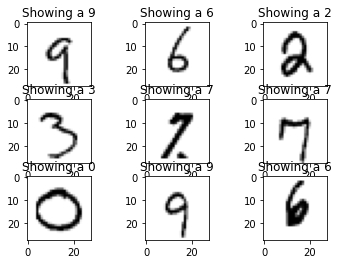

In [3]:
import numpy as np
import matplotlib.pyplot as plt

print('X shape: ' + repr(X_train_full.shape) , ' - type: ' + str(X_train_full.dtype))
print('y shape: ' + repr(y_train_full.shape) , ' - type: ' + str(X_train_full.dtype))

tmpidxs = np.random.permutation( X_train_full.shape[0] )[:9]

plt.clf()
for i in range(9):
    plt.subplot(3,3,i+1)
    tmp_idx = tmpidxs[i]
    plt.imshow(X_train_full[tmp_idx,:,:], cmap='gray_r')
    plt.title('Showing a ' + str( y_train_full[tmp_idx] ) )
plt.show()

In [4]:
# also readjust range to float 0-1 for gradient descend training

X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.

In [5]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstruction(model, X, n_images=5):
    reconstruction_idxs = np.random.permutation(np.arange(X.shape[0]))[:n_images]
    reconstructions = model.predict(X[reconstruction_idxs])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X[reconstruction_idxs[image_index]])
        plt.subplot(2, n_images, 1 + image_index + n_images)
        plot_image( reconstructions[image_index] )

In [6]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dense_2 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 136,634
Trainable params: 136,634
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)          

In [7]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [8]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices( tf.cast(X_train, tf.float32) ).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [9]:
import progressbar

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        progress = 0.
        string2print = 'Epoch ' + str(epoch) + ': ' + 'd: ' + ' X ' + ' - g: ' + ' X' + ' |'
        widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(), ' ', progressbar.FormatLabel( string2print ) ]
        # widgets = [progressbar.FormatLabel(''), ' ', progressbar.Percentage(), ' ', progressbar.Bar('/'), ' ', progressbar.RotatingMarker()]
        bar = progressbar.ProgressBar(maxval=1, widgets=widgets)
        bar.start()
        for X_batch in dataset:
            progress += 1/dataset.cardinality().numpy()
            progress = min( progress , 1 )
            # 1 - train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainable = True
            discr_error = discriminator.train_on_batch(X_fake_and_real, y1)
            # 2 - train generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            gan_error = gan.train_on_batch(noise, y2)
            string2print = 'Epoch ' + str(epoch) + '| ' + 'd: ' + '{:.4f}'.format(discr_error) + ' - g: ' + '{:.4f}'.format(gan_error)
            widgets[4] = progressbar.FormatLabel( string2print )
            bar.update(progress)
        # print( 'epoch: ' + str(epoch) + ' - discriminator: ' + str(discr_error) + ' - gan: ' + str(gan_error) )
        # d_pred = discriminator.predict( X_train )
        # d_error = tf.metrics.binary_crossentropy( y_train , d_pred )
        # g_pred = gan.predict( X_train )
        # g_error = tf.metrics.binary_crossentropy( y_train , d_pred )
        # string2print = 'Epoch ' + str(epoch) + '| ' + 'd: ' + '{:.4f}'.format(d_error) + ' - g: ' + '{:.4f}'.format(gan_error)
        # widgets[4] = progressbar.FormatLabel( string2print )
        # bar.update(progress)
        bar.finish()

In [10]:
train_gan(gan, dataset, batch_size, codings_size)

[=========================================] 100% Epoch 0| d: 0.0025 - g: 8.6294
[=========================================] 100% Epoch 1| d: 0.0811 - g: 3.4249
[=========================================] 100% Epoch 2| d: 0.2640 - g: 2.6761
[=========================================] 100% Epoch 3| d: 0.1976 - g: 3.1179
[=========================================] 100% Epoch 4| d: 0.2196 - g: 2.9201
[=========================================] 100% Epoch 5| d: 0.2130 - g: 2.7620
[=========================================] 100% Epoch 6| d: 0.2960 - g: 2.7488
[=========================================] 100% Epoch 7| d: 0.2377 - g: 2.2805
[=========================================] 100% Epoch 8| d: 0.3834 - g: 2.9174
[=========================================] 100% Epoch 9| d: 0.3550 - g: 3.3256
[========================================] 100% Epoch 10| d: 0.2936 - g: 3.1945
[========================================] 100% Epoch 11| d: 0.2479 - g: 2.6270
[=======================================

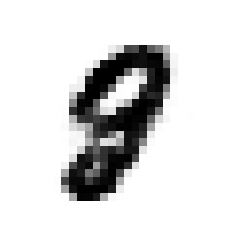

In [32]:
random_input = np.random.rand(1, codings_size)
y = generator.predict( random_input )
plot_image(y[0,:,:])